# Market Surveillance for Unusual Market Movements: An Autoencoder Approach


## 1. Setting the Stage: Essential Tools for Market Surveillance

As a Quant Analyst at Apex Asset Management, my first step in setting up our market surveillance system is to ensure I have all the necessary Python libraries installed. These tools will enable me to collect market data, build and train deep learning models, perform statistical analysis, and visualize our findings. This foundational setup is critical for any robust analytical workflow.


### Required Library Installation


In [ ]:
!pip install yfinance pandas numpy tensorflow scikit-learn matplotlib seaborn scipy


### Importing Essential Libraries


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # For progress bars, enhancing user experience
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


---

## 2. Acquiring and Preparing Multi-Asset Market Data

My firm, Apex Asset Management, manages a diversified multi-asset portfolio. To effectively monitor for unusual movements, I need to collect historical daily data for a broad universe of assets including equities, bonds, commodities, and currencies. I'll then transform this raw price data into daily returns and engineer additional cross-sectional features that capture market dynamics beyond individual asset movements.


### Market Data Acquisition and Feature Engineering


In [ ]:
def acquire_and_preprocess_market_data(start_date='2008-01-01', end_date='2024-12-31'):
    """
    Acquires multi-asset market data from Yahoo Finance, calculates returns,
    and engineers cross-sectional features.
    """
    tickers = {
        '^GSPC': 'SP500', '^DJI': 'DJIA', '^IXIC': 'NASDAQ', '^RUT': 'Russell2000',
        'TLT': 'LongBond', 'IEF': 'MedBond', 'SHY': 'ShortBond',
        'GLD': 'Gold', 'USO': 'Oil', 'UUP': 'USD',
        'EEM': 'EmergMkt', 'VGK': 'Europe', 'EWJ': 'Japan',
        '^VIX': 'VIX'
    }

    print(f"Downloading data for {len(tickers)} assets from {start_date} to {end_date}...")
    data = yf.download(list(tickers.keys()), start=start_date, end=end_date)['Close']
    data.columns = [tickers.get(c, c) for c in data.columns]

    # Calculate daily percentage change (returns)
    returns = data.pct_change().dropna()

    # Add cross-sectional features: mean correlation and cross-sectional volatility
    # Use only primary assets for correlation, excluding VIX which is a volatility index
    primary_assets = [col for col in returns.columns if col not in ['VIX']]

    # Calculate rolling mean correlation
    print("Calculating cross-sectional correlation...")

    # Define a custom function to get the mean of the upper triangle of a correlation matrix
    def get_mean_pairwise_correlation(corr_matrix_df):
        if corr_matrix_df.empty or corr_matrix_df.isnull().all().all():
            return np.nan
        # Ensure it's a square matrix for correlation
        if corr_matrix_df.shape[0] != corr_matrix_df.shape[1]:
            return np.nan

        # Get upper triangle without diagonal, then stack and take mean
        upper_tri = corr_matrix_df.where(np.triu(np.ones(corr_matrix_df.shape), k=1).astype(bool))
        return upper_tri.stack().mean()

    # Calculate rolling correlation matrices, then apply the custom function to each group (date)
    # This results in a Series indexed by date, which can then be smoothed by another rolling mean.
    rolling_correlations = returns[primary_assets].rolling(window=20).corr()
    mean_corr_per_day = rolling_correlations.groupby(level=0).apply(get_mean_pairwise_correlation)
    returns['cross_corr'] = mean_corr_per_day.rolling(window=20).mean()

    # Calculate rolling cross-sectional volatility (standard deviation of returns across assets)
    print("Calculating cross-sectional volatility...")
    # This calculation should be fine as .std() on a rolling object returns a DataFrame with a single index.
    returns['cross_vol'] = returns[primary_assets].rolling(window=20).std().mean(axis=1)

    returns = returns.dropna() # Drop NA from rolling calculations

    # Known anomaly dates (for later evaluation and visualization)
    anomaly_dates_str = [
        '2008-09-15', '2008-10-15', '2010-05-06', '2011-08-08', '2015-08-24',
        '2018-02-05', '2020-03-12', '2020-03-16', '2022-06-13'
    ]
    known_anomaly_dates = pd.to_datetime(anomaly_dates_str)

    print(f"\nDataset prepared: {returns.shape[0]} days x {returns.shape[1]} features")
    print(f"First 5 rows of returns data:\n{returns.head()}")

    # Print S&P 500 returns for known anomaly dates
    print("\nKnown anomaly dates (and S&P 500 returns):")
    for d in known_anomaly_dates:
        d_str = d.strftime('%Y-%m-%d')
        if d in returns.index:
            print(f" {d_str}: SP500 return = {returns.loc[d, 'SP500']:.2%}")
        else:
            print(f" {d_str}: Date not found in dataset.")

    return returns, known_anomaly_dates

# Execute the data acquisition and preprocessing
market_returns, known_anomaly_dates = acquire_and_preprocess_market_data()

[*********************100%***********************]  14 of 14 completed


Calculating cross-sectional correlation...
Calculating cross-sectional volatility...

Dataset prepared: 4239 days x 16 features
First 5 rows of returns data:
            EmergMkt     Japan      Gold   MedBond  ShortBond  LongBond  \
Date                                                                      
2008-02-28 -0.010750 -0.010920  0.012766  0.011717   0.002390  0.017765   
2008-02-29 -0.039752 -0.011830  0.001979  0.010689   0.003457  0.015300   
2008-03-03  0.005443 -0.000798  0.011021 -0.002542   0.000035 -0.002578   
2008-03-04 -0.023222 -0.023163 -0.021185 -0.003768  -0.000238 -0.009717   
2008-03-05  0.021003  0.005724  0.026686 -0.004337  -0.000594 -0.011971   

                 Oil       USD    Europe      DJIA     SP500    NASDAQ  \
Date                                                                     
2008-02-28  0.032438 -0.005635 -0.006424 -0.008831 -0.008942 -0.009436   
2008-02-29 -0.013009  0.000436 -0.024425 -0.025098 -0.027090 -0.025772   
2008-03-03  0.011191

### Data Preprocessing and Splitting for Autoencoder Training


In [ ]:
def prepare_data_for_ae(returns_df, train_end_date='2023-01-01', feature_cols=None):
    """
    Scales the market data and splits it into training and testing sets.
    The training set aims to represent 'normal' market behavior.
    """
    if feature_cols is None:
        # Exclude 'VIX' from features used by AE if VIX is intended for coloring latent space,
        # or if it's considered an outcome rather than an input for normal market dynamics.
        # For this lab, let's keep VIX in for the AE to learn its relation to other assets,
        # but the original text suggested excluding cross_corr for AE, I'll follow that.
        feature_cols = [col for col in returns_df.columns if col not in ['cross_corr', 'cross_vol']]

    X = returns_df[feature_cols]

    # Standardize features to zero mean and unit variance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

    # Split data into training and test sets
    # Training period to learn 'normal' behavior
    train_mask = X_scaled_df.index < train_end_date
    test_mask = X_scaled_df.index >= train_end_date

    X_train = X_scaled_df[train_mask]
    X_test = X_scaled_df[test_mask]

    print(f"\nTraining set: {X_train.shape[0]} days, {X_train.shape[1]} features")
    print(f"Test set: {X_test.shape[0]} days")
    print(f"Features used for Autoencoder: {feature_cols}")

    return X_train, X_test, scaler, train_mask, test_mask, feature_cols

# Define the end date for the training period
TRAIN_END_DATE = '2023-01-01'
X_train, X_test, scaler, train_mask, test_mask, ae_features = prepare_data_for_ae(market_returns, TRAIN_END_DATE)



Training set: 3738 days, 14 features
Test set: 501 days
Features used for Autoencoder: ['EmergMkt', 'Japan', 'Gold', 'MedBond', 'ShortBond', 'LongBond', 'Oil', 'USD', 'Europe', 'DJIA', 'SP500', 'NASDAQ', 'Russell2000', 'VIX']


---

## 3. Building an Autoencoder to Model 'Normal' Market Dynamics

As a Quant Analyst, my goal is to build a model that can discern the intricate, non-linear relationships and typical co-movements among assets during 'normal' market conditions. An Autoencoder (AE) is perfect for this. It's an unsupervised neural network that learns to compress its input into a low-dimensional "latent space" and then reconstruct it. By forcing the network to reconstruct its own input, it learns the most salient features and patterns.

The architecture will be symmetric: an encoder maps the high-dimensional input to a bottleneck (latent space), and a decoder maps from the bottleneck back to the original input dimension. The critical part is the bottleneck, which acts as a "non-linear PCA" by forcing the model to learn a compact representation of the data. If the model can reconstruct data points well, they are considered 'normal'. If it struggles, they are potentially anomalous.


### Autoencoder Architecture Definition

The autoencoder learns a mapping $E: \mathcal{X} \rightarrow \mathcal{Z}$ for the encoder and $D: \mathcal{Z} \rightarrow \mathcal{X}$ for the decoder, where $\mathcal{X}$ is the input space and $\mathcal{Z}$ is the latent space. The objective is to minimize the reconstruction error $\mathcal{L}_{AE}(x_i, D(E(x_i)))$.


In [ ]:
def build_autoencoder(input_dim, encoding_dim=4, hidden_dims=[32, 16], dropout_rate=0.2):
    """
    Constructs a symmetric dense autoencoder for anomaly detection.

    Args:
        input_dim (int): The number of input features.
        encoding_dim (int): The dimension of the bottleneck (latent space).
        hidden_dims (list): A list of integers specifying the number of units
                            in each hidden layer of the encoder/decoder.
        dropout_rate (float): The dropout rate applied to hidden layers.

    Returns:
        tuple: A tuple containing the full autoencoder model and the encoder-only model.
    """
    inputs = Input(shape=(input_dim,), name='input_layer')
    x = inputs

    # Encoder
    for i, dim in enumerate(hidden_dims):
        x = Dense(dim, activation='relu', name=f'encoder_hidden_{i+1}')(x)
        x = BatchNormalization(name=f'encoder_bn_{i+1}')(x)
        x = Dropout(dropout_rate, name=f'encoder_dropout_{i+1}')(x)

    # Bottleneck (latent representation)
    latent = Dense(encoding_dim, activation='relu', name='bottleneck_layer')(x)

    # Decoder (mirror of encoder)
    x = latent
    for i, dim in enumerate(reversed(hidden_dims)):
        x = Dense(dim, activation='relu', name=f'decoder_hidden_{i+1}')(x)
        x = BatchNormalization(name=f'decoder_bn_{i+1}')(x)
        x = Dropout(dropout_rate, name=f'decoder_dropout_{i+1}')(x)

    # Output layer (reconstruct input)
    outputs = Dense(input_dim, activation='linear', name='output_layer')(x)

    # Full autoencoder model
    autoencoder = Model(inputs, outputs, name='autoencoder')

    # Encoder-only model for latent space visualization
    encoder = Model(inputs, latent, name='encoder')

    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder

# Determine input dimension from our training data
input_dim = X_train.shape[1]

# Build the autoencoder with a 4-dimensional latent space
# The bottleneck dimension (e.g., 4) encodes our belief about market complexity,
# analogous to how factor models describe returns with a few latent factors.
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim=4, hidden_dims=[32, 16])

# Display the model summary to understand its layers and parameters
print("Autoencoder Model Summary:")
autoencoder.summary()


Autoencoder Model Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_hidden_1 (Dense)        │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_hidden_2 (Dense)        │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_2 (Dropout)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_layer (Dense)        │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden_1 (Dense)        │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_1                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_1 (Dropout)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden_2 (Dense)        │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_2                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_2 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546 (9.95 KB)

 Trainable params: 2,354 (9.20 KB)

 Non-trainable params: 192 (768.00 B)

### Explanation of Autoencoder Architecture

The autoencoder's goal is to minimize the Mean Squared Error (MSE) between its input $x$ and its reconstructed output $\hat{x}$. This forces the network to learn an efficient, compressed representation of the input data in the latent space.
$$
\mathcal{L}_{AE} = \frac{1}{N} \sum_{i=1}^{N} \|x_i - \hat{x}_i\|^2
$$
Here, $x_i$ is the original input, and $\hat{x}_i = D(E(x_i))$ is the reconstructed output. For a Risk Manager, this means the model learns the "normal" manifold of market movements. Data points that lie far from this manifold will be poorly reconstructed, leading to a high reconstruction error, which serves as our anomaly score. The `encoding_dim` (bottleneck size) is a critical hyperparameter:
*   Too large: The autoencoder might simply memorize the input, including anomalies, leading to low reconstruction error for everything and no useful signal.
*   Too small: Too much information is lost, and everything might look anomalous.
The chosen size (4 for financial data with ~15 features) typically forces the model to capture only the most important structural relationships.


---

## 4. Training the Autoencoder on Normal Market Behavior

Now that the autoencoder architecture is defined, I will train it using the historical market return data from our designated "normal" period. It's crucial that the model learns the patterns of typical market behavior. I'll use `EarlyStopping` to prevent overfitting and ensure the model generalizes well, stopping training when the validation loss no longer improves.


### Autoencoder Training


In [ ]:
def train_autoencoder(model, X_train_data, epochs=100, batch_size=64, validation_split=0.15, patience=10):
    """
    Trains the autoencoder model on the provided training data.

    Args:
        model (tf.keras.Model): The autoencoder model to train.
        X_train_data (np.array): The training data.
        epochs (int): Maximum number of epochs to train for.
        batch_size (int): Number of samples per gradient update.
        validation_split (float): Fraction of the training data to be used as validation data.
        patience (int): Number of epochs with no improvement after which training will be stopped.

    Returns:
        tf.keras.callbacks.History: Training history object.
    """
    print(f"\nTraining autoencoder on {X_train_data.shape[0]} samples...")
    # Callbacks for early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train_data, X_train_data,  # Input = Target (self-reconstruction)
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping],
        shuffle=True,
        verbose=0 # Suppress verbose output for cleaner notebook, tqdm will provide progress
    )
    print("Autoencoder training complete.")
    return history

# Train the autoencoder
ae_training_history = train_autoencoder(autoencoder, X_train, epochs=100, batch_size=64, validation_split=0.15, patience=10)



Training autoencoder on 3738 samples...
Autoencoder training complete.


### Visualization of Training Progress


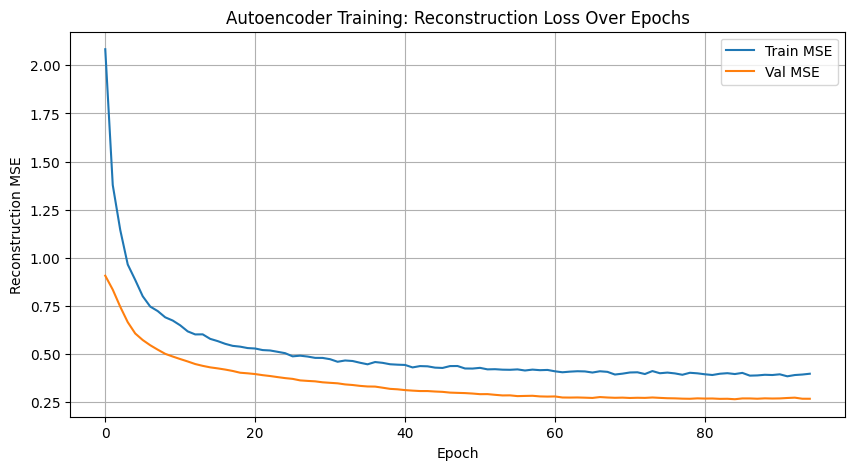

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation loss curves.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(ae_training_history.history['loss'], label='Train MSE')
    plt.plot(ae_training_history.history['val_loss'], label='Val MSE')
    plt.title('Autoencoder Training: Reconstruction Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(ae_training_history)


### Explanation of Training Results

The training loss curves demonstrate how well the autoencoder learned to reconstruct 'normal' market behavior. A converging loss indicates that the model is successfully identifying underlying patterns. The `val_loss` is crucial: if it starts increasing while `loss` continues to decrease, it's a sign of overfitting to the training data, which `EarlyStopping` helps to mitigate by restoring the best weights. For me, the Quant Analyst, this plot confirms the model has effectively learned a baseline of "normalcy," a prerequisite for robust anomaly detection.


---

## 5. Detecting Anomalies: Identifying Unusual Market Movements with Reconstruction Error

With a trained autoencoder, I can now move to the core task: detecting unusual market movements. This involves using the autoencoder to reconstruct both training and test data and then calculating the "reconstruction error" for each day. Days with significantly higher reconstruction errors are flagged as potential anomalies. I will set a statistical threshold based on the distribution of errors from the training set, which represents normal behavior.


### Calculating Reconstruction Errors and Setting Anomaly Thresholds

The reconstruction error $e_i$ for a given input $x_i$ is calculated as the Mean Squared Error (MSE) between the original input and its reconstruction $\hat{x}_i$:
$$
e_i = \frac{1}{F} \sum_{j=1}^{F} (x_{ij} - \hat{x}_{ij})^2
$$
where $F$ is the number of features, $x_{ij}$ is the $j$-th feature of the $i$-th observation, and $\hat{x}_{ij}$ is its reconstructed value.

To classify an observation as anomalous, its reconstruction error $e_i$ must exceed a predefined threshold $\tau$.
$$
\text{Anomaly}_i = \begin{cases} 1 & \text{if } e_i > \tau \\ 0 & \text{otherwise} \end{cases}
$$
For thresholding, I will use percentile-based methods on the training errors, as they are simple and robust. I will consider the 95th and 99th percentiles to represent moderate and extreme anomaly thresholds, respectively.


In [ ]:
def calculate_reconstruction_errors(model, X_data):
    """
    Predicts reconstructions and calculates the reconstruction error (MSE) for each sample.
    """
    X_pred = model.predict(X_data, verbose=0)
    # Calculate MSE for each sample across all features
    errors = np.mean(np.square(X_data - X_pred), axis=1)
    return errors

def set_anomaly_thresholds(train_errors, percentiles=[95, 99]):
    """
    Calculates percentile-based anomaly thresholds from training reconstruction errors.
    """
    thresholds = {p: np.percentile(train_errors, p) for p in percentiles}
    return thresholds

# Calculate reconstruction errors for training and test sets
train_recon_errors = calculate_reconstruction_errors(autoencoder, X_train)
test_recon_errors = calculate_reconstruction_errors(autoencoder, X_test)

# Set anomaly thresholds using the training errors
anomaly_thresholds = set_anomaly_thresholds(train_recon_errors, percentiles=[95, 99])

print(f"Training error stats: Mean={np.mean(train_recon_errors):.4f}, Std={np.std(train_recon_errors):.4f}")
for p, t in anomaly_thresholds.items():
    print(f"Threshold ({p}th percentile): {t:.4f}")

# Flag anomalies in the test set
test_dates = market_returns.index[test_mask]
anomaly_flags_99 = test_recon_errors > anomaly_thresholds[99]
anomaly_flags_95 = test_recon_errors > anomaly_thresholds[95]

n_anomalies_99 = anomaly_flags_99.sum()
n_anomalies_95 = anomaly_flags_95.sum()

print(f"\nAnomalies detected (99th percentile): {n_anomalies_99} / {len(test_recon_errors)} ({n_anomalies_99 / len(test_recon_errors):.1%})")
print(f"Anomalies detected (95th percentile): {n_anomalies_95} / {len(test_recon_errors)} ({n_anomalies_95 / len(test_recon_errors):.1%})")

# Create a DataFrame to summarize test set results
anomaly_results_df = pd.DataFrame({
    'date': test_dates,
    'recon_error': test_recon_errors,
    'SP500_ret': market_returns.loc[test_mask, 'SP500'].values,
    'VIX': market_returns.loc[test_mask, 'VIX'].values,
    'anomaly_flag_99': anomaly_flags_99,
    'anomaly_flag_95': anomaly_flags_95
}).set_index('date')

# Show top 10 anomalous days by reconstruction error
top_anomalies_df = anomaly_results_df.nlargest(10, 'recon_error')
print("\nTop 10 anomalous days by reconstruction error (99th percentile threshold is for visualization):")
print(top_anomalies_df[['recon_error', 'SP500_ret', 'VIX', 'anomaly_flag_99']].to_string())


Training error stats: Mean=0.2513, Std=0.4345
Threshold (95th percentile): 0.7604
Threshold (99th percentile): 2.0623

Anomalies detected (99th percentile): 4 / 501 (0.8%)
Anomalies detected (95th percentile): 20 / 501 (4.0%)

Top 10 anomalous days by reconstruction error (99th percentile threshold is for visualization):
            recon_error  SP500_ret       VIX  anomaly_flag_99
date                                                         
2023-03-13     5.915939  -0.001510  0.069355             True
2024-12-18     3.522621  -0.029493  0.740391             True
2024-08-05     2.415390  -0.029969  0.648995             True
2024-08-02     2.219897  -0.018382  0.258203             True
2023-03-15     1.960624  -0.006981  0.101559            False
2024-11-06     1.806555   0.025296 -0.205954            False
2023-03-10     1.276730  -0.014478  0.096860            False
2023-12-13     1.228053   0.013651  0.009942            False
2023-11-14     1.174866   0.019075 -0.040650            F

### Visualization of Reconstruction Error Distribution


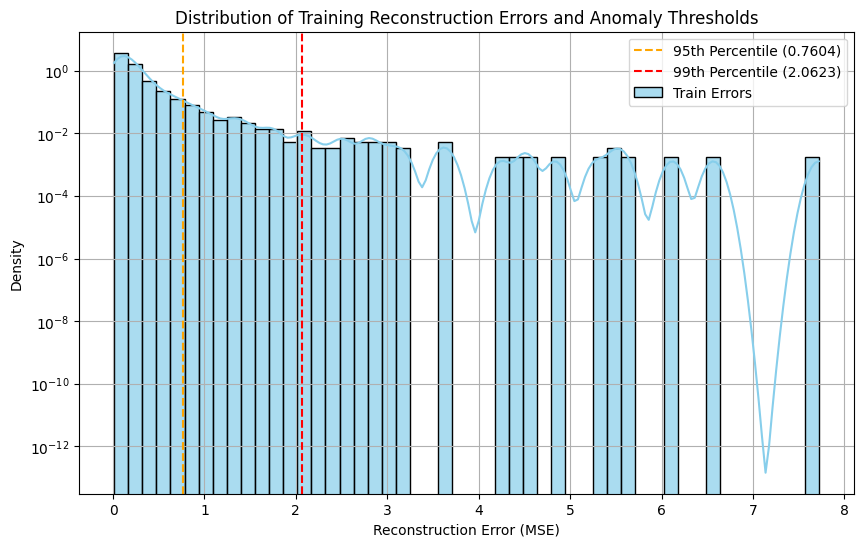

In [ ]:
def plot_error_distribution(train_errors, thresholds):
    """
    Plots a histogram of training reconstruction errors with anomaly thresholds.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(train_errors, bins=50, kde=True, stat='density', alpha=0.7, color='skyblue', label='Train Errors')

    for p, t in thresholds.items():
        plt.axvline(x=t, color='red' if p == 99 else 'orange', linestyle='--', label=f'{p}th Percentile ({t:.4f})')

    plt.title('Distribution of Training Reconstruction Errors and Anomaly Thresholds')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.yscale('log') # Log scale helps visualize the heavy tail of errors
    plt.show()

plot_error_distribution(train_recon_errors, anomaly_thresholds)


### Explanation of Anomaly Detection

This step provides the quantitative basis for anomaly detection. The histogram of training errors typically shows a heavy-tailed distribution, where the bulk of 'normal' market days have low errors, and extreme events correspond to the long tail. By setting thresholds at the 95th or 99th percentile, I am defining what constitutes a statistically significant deviation from normal. For Apex Asset Management, this allows for a consistent and data-driven approach to flagging market events that warrant further investigation, moving beyond arbitrary fixed thresholds.


---

## 6. Visualizing Anomalies and Their Drivers for Deeper Insight

Detecting an anomaly is only the first step. As a Quant Analyst, I need to visualize these flagged dates in the context of broader market movements and, crucially, understand *what* specifically made them anomalous. This helps in root cause analysis and informs risk mitigation strategies. I'll create a dual-panel time series plot and then drill down into per-feature errors for the most anomalous days.


### Visualizing Reconstruction Error Time Series


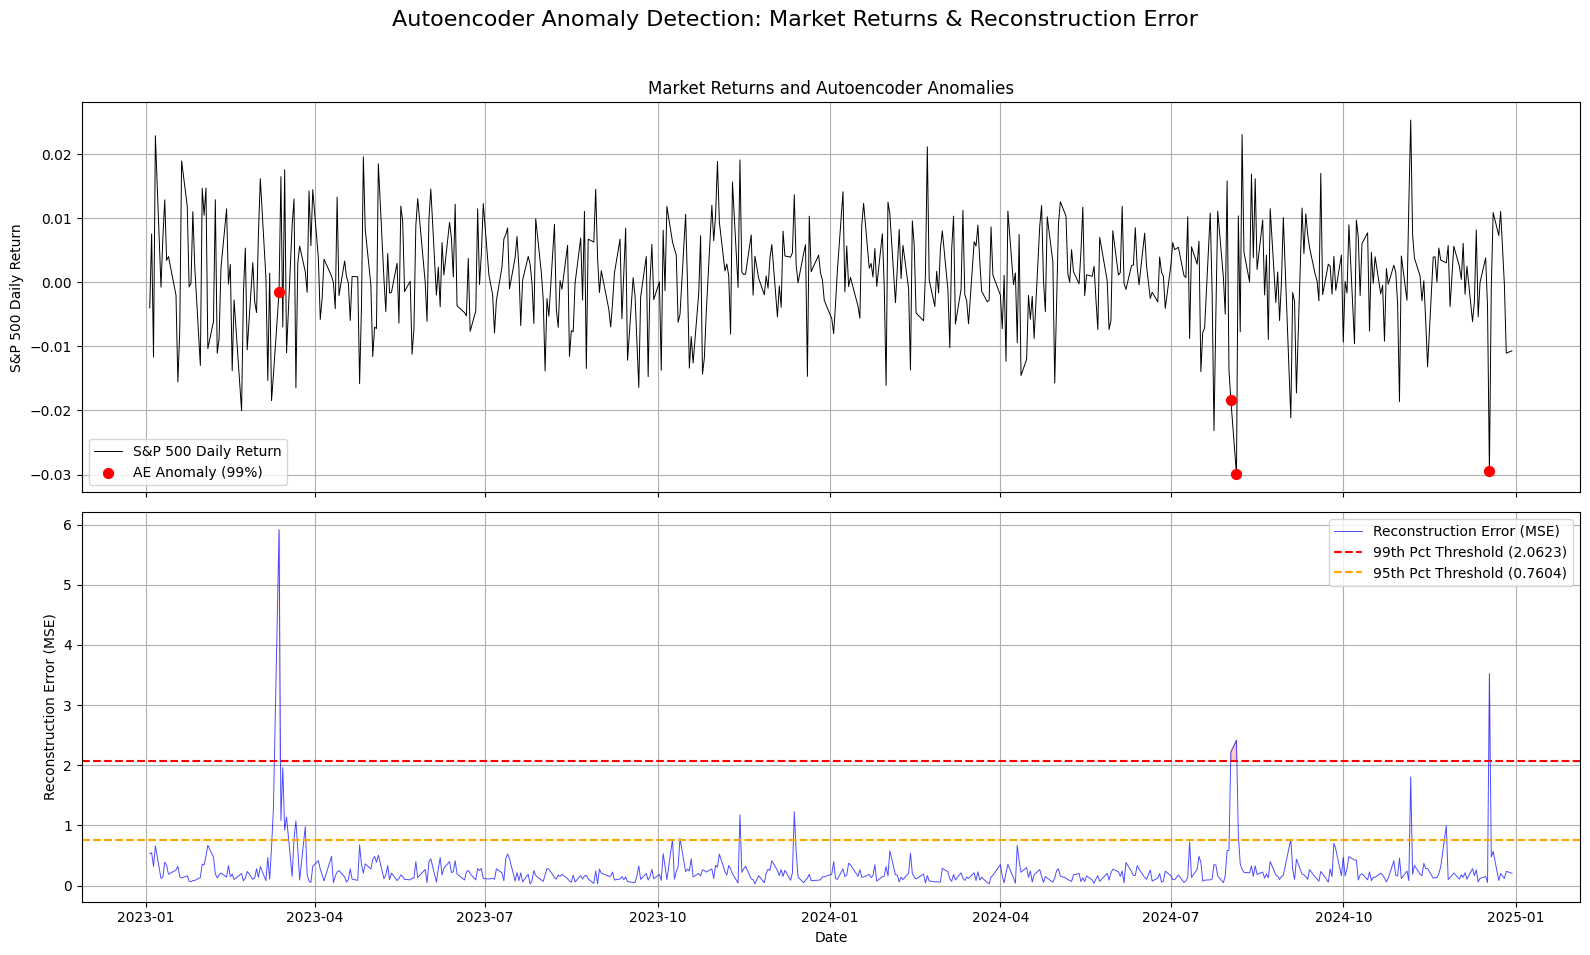

In [ ]:
def plot_anomaly_time_series(anomaly_df, thresholds, known_dates):
    """
    Generates a dual-panel plot showing S&P 500 returns, reconstruction errors,
    anomaly thresholds, and flagged dates.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

    # Top panel: S&P 500 returns with flagged anomalies
    ax1.plot(anomaly_df.index, anomaly_df['SP500_ret'], color='black', linewidth=0.7, label='S&P 500 Daily Return')

    # Highlight known anomaly dates
    known_anom_in_test = anomaly_df.index.intersection(known_dates)
    if not known_anom_in_test.empty:
        ax1.scatter(known_anom_in_test, anomaly_df.loc[known_anom_in_test, 'SP500_ret'],
                    marker='o', color='purple', s=70, zorder=6, label='Known Market Event')

    # Highlight model-flagged anomalies (99th percentile)
    model_anom_dates = anomaly_df[anomaly_df['anomaly_flag_99']].index
    if not model_anom_dates.empty:
        ax1.scatter(model_anom_dates, anomaly_df.loc[model_anom_dates, 'SP500_ret'],
                    c='red', s=50, zorder=5, label='AE Anomaly (99%)')

    ax1.set_ylabel('S&P 500 Daily Return')
    ax1.set_title('Market Returns and Autoencoder Anomalies')
    ax1.legend()
    ax1.grid(True)

    # Bottom panel: Reconstruction error with thresholds
    ax2.plot(anomaly_df.index, anomaly_df['recon_error'], color='blue', linewidth=0.7, alpha=0.7, label='Reconstruction Error (MSE)')

    # Add anomaly thresholds
    ax2.axhline(y=thresholds[99], color='red', linestyle='--', label=f'99th Pct Threshold ({thresholds[99]:.4f})')
    ax2.axhline(y=thresholds[95], color='orange', linestyle='--', label=f'95th Pct Threshold ({thresholds[95]:.4f})')

    # Highlight area above 99th percentile threshold
    ax2.fill_between(anomaly_df.index, thresholds[99], anomaly_df['recon_error'],
                     where=(anomaly_df['recon_error'] > thresholds[99]), color='red', alpha=0.2)

    ax2.set_xlabel('Date')
    ax2.set_ylabel('Reconstruction Error (MSE)')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle('Autoencoder Anomaly Detection: Market Returns & Reconstruction Error', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

plot_anomaly_time_series(anomaly_results_df, anomaly_thresholds, known_anomaly_dates)


### Per-Feature Error Analysis (Anomaly Gallery & Heatmap)

A high total reconstruction error tells me *that* something is anomalous, but not *what*. Per-feature error analysis helps pinpoint the specific assets or features that contributed most to the anomaly. The per-feature reconstruction error for observation $i$ and feature $j$ is simply $(x_{ij} - \hat{x}_{ij})^2$. Summing this over selected anomalous days can highlight consistently problematic features.



Analyzing per-feature errors for 5 anomalous days...


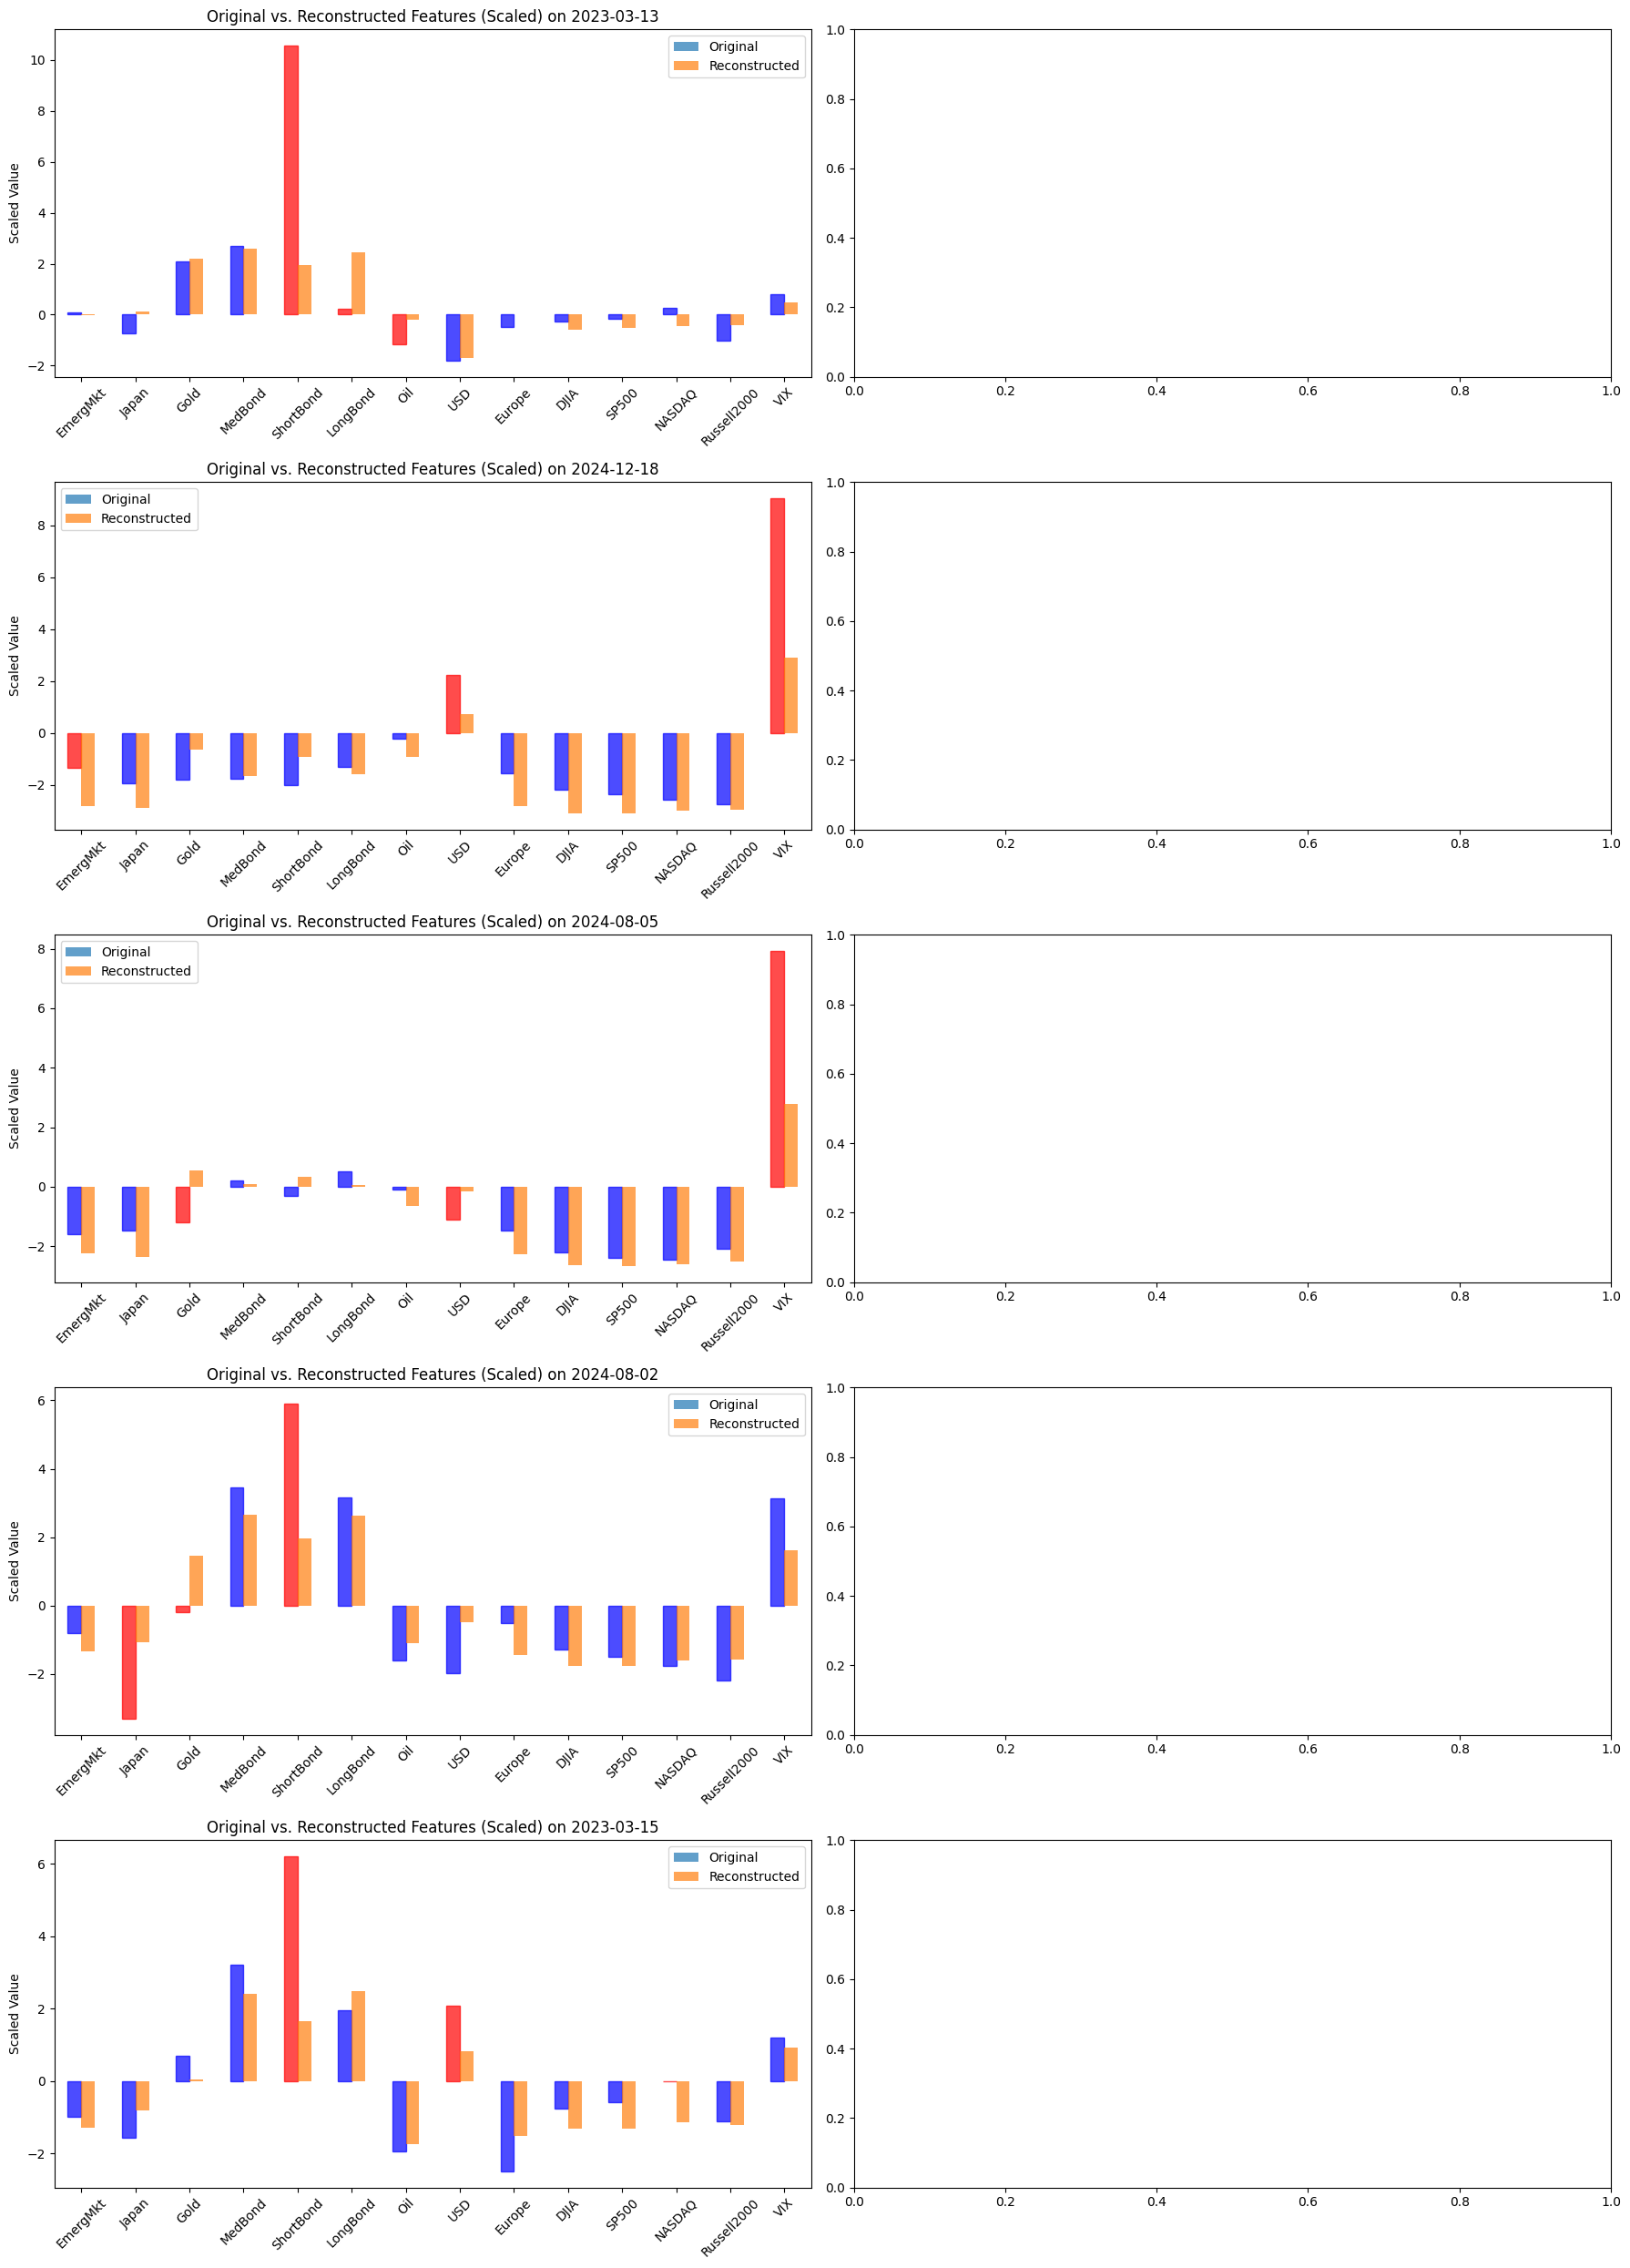

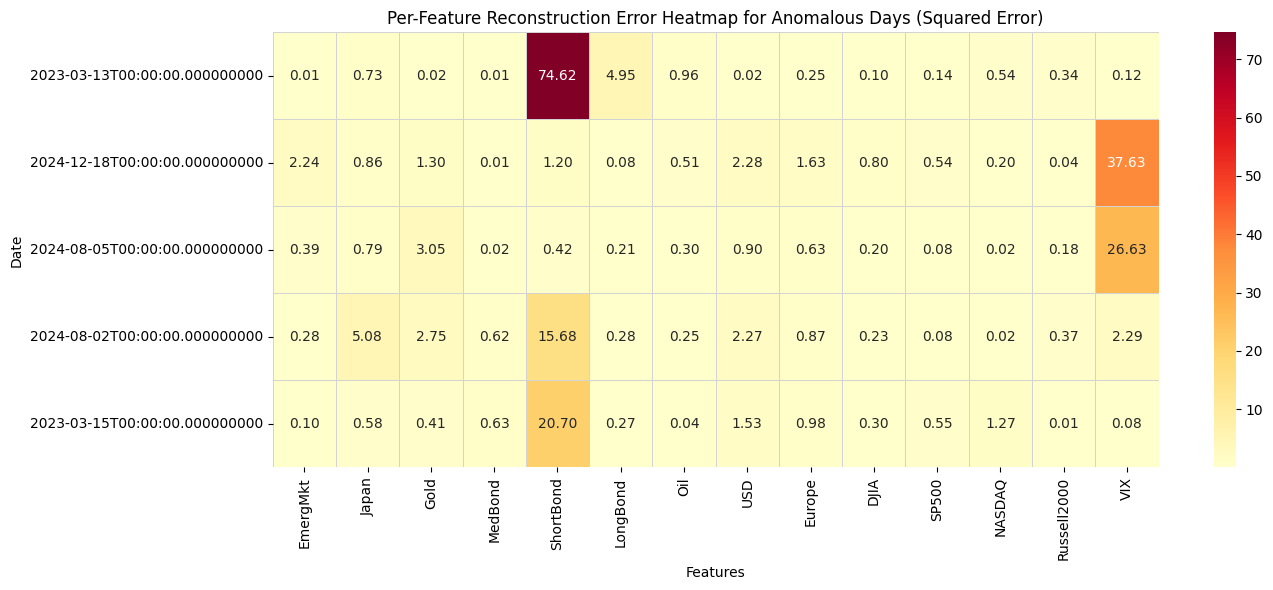

In [ ]:
def analyze_per_feature_errors(model, X_data_scaled_df, original_df, anomaly_dates_to_analyze, scaler, feature_names):
    """
    Calculates and visualizes per-feature reconstruction errors for selected anomalous dates.
    Shows an "anomaly gallery" (original vs. reconstructed) and a heatmap of feature errors.
    """
    print(f"\nAnalyzing per-feature errors for {len(anomaly_dates_to_analyze)} anomalous days...")

    per_feature_errors = pd.DataFrame(index=anomaly_dates_to_analyze, columns=feature_names)
    X_pred_all = model.predict(X_data_scaled_df, verbose=0)
    X_pred_df = pd.DataFrame(X_pred_all, index=X_data_scaled_df.index, columns=feature_names)

    fig, axes = plt.subplots(len(anomaly_dates_to_analyze), 2, figsize=(18, 5 * len(anomaly_dates_to_analyze)))
    if len(anomaly_dates_to_analyze) == 1: # Handle single row subplot case
        axes = [axes]

    for i, date in enumerate(anomaly_dates_to_analyze):
        if date not in X_data_scaled_df.index:
            print(f"Warning: Date {date.strftime('%Y-%m-%d')} not found in scaled data. Skipping.")
            continue

        original_scaled_features = X_data_scaled_df.loc[date].values
        reconstructed_scaled_features = X_pred_df.loc[date].values

        # Calculate per-feature squared error
        feature_squared_errors = np.square(original_scaled_features - reconstructed_scaled_features)
        per_feature_errors.loc[date] = feature_squared_errors

        # Anomaly Gallery: Original vs. Reconstructed
        df_plot = pd.DataFrame({
            'Original': original_scaled_features,
            'Reconstructed': reconstructed_scaled_features
        }, index=feature_names)

        ax = axes[i][0] if len(anomaly_dates_to_analyze) > 1 else axes[0][0]
        df_plot.plot(kind='bar', ax=ax, alpha=0.7)
        ax.set_title(f'Original vs. Reconstructed Features (Scaled) on {date.strftime("%Y-%m-%d")}')
        ax.set_ylabel('Scaled Value')
        ax.tick_params(axis='x', rotation=45)

        # Highlight features with highest error
        top_error_features = df_plot['Original'].index[np.argsort(feature_squared_errors)[-3:]]
        colors = ['red' if f in top_error_features else 'blue' for f in df_plot.index]
        for bar, color in zip(ax.patches, colors):
            bar.set_color(color)

    plt.tight_layout()
    plt.show()

    # Per-feature error heatmap
    plt.figure(figsize=(14, 0.8 * len(anomaly_dates_to_analyze) + 2))
    sns.heatmap(per_feature_errors.astype(float), cmap='YlOrRd', annot=True, fmt=".2f", linewidths=.5, linecolor='lightgray')
    plt.title('Per-Feature Reconstruction Error Heatmap for Anomalous Days (Squared Error)')
    plt.xlabel('Features')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()

# Select top 5 anomalous days by reconstruction error for detailed analysis
top_5_anomaly_dates = top_anomalies_df.index[:5]
analyze_per_feature_errors(autoencoder, X_test, market_returns, top_5_anomaly_dates, scaler, ae_features)


### Explanation of Anomaly Visualizations and Drivers

The dual-panel time series plot gives me, the Quant Analyst, an immediate visual context. I can see the market's reaction (S&P 500 returns) alongside the autoencoder's reconstruction error. Crucially, the flagged red dots indicate days where our autoencoder detected significant anomalies. This allows for qualitative validation against known market events or periods of high volatility.

The "anomaly gallery" (original vs. reconstructed feature plot) and the heatmap are invaluable for triage. They answer the critical question: *what* was anomalous? For example, if on a particular day, bond returns were severely poorly reconstructed while equity returns were fine, it might signal an unusual bond-equity correlation breakdown, rather than a broad market crash. This level of detail aids in root cause analysis and proactive risk mitigation.

**Practitioner Warning: Anomaly $
eq$ Crisis.** It's essential for me to remember that not every flagged day is a market crisis. Some might be "structural anomalies" (e.g., cross-asset correlations shifting subtly), data quality issues, or model artifacts. The autoencoder detects *statistical* anomalies; human judgment is non-negotiable to determine financial meaningfulness and decide on appropriate actions. This human-in-the-loop interpretation is vital for production deployment at Apex Asset Management.


---

## 7. Uncovering Hidden Market Regimes: Latent Space Analysis

Beyond just flagging anomalies, I want to understand what patterns the autoencoder has learned about "normal" market structure. Visualizing the compressed "latent space" can reveal how different market regimes or conditions cluster. By training a specialized autoencoder with a 2D latent space and coloring the points by a market regime proxy (like VIX Daily Change), I can gain insights into the model's structural learning.


### Training a 2D Latent Space Autoencoder and Visualization



Training 2D latent space autoencoder (encoding_dim=2)...

Training autoencoder on 3738 samples...
Autoencoder training complete.
2D Autoencoder training complete.


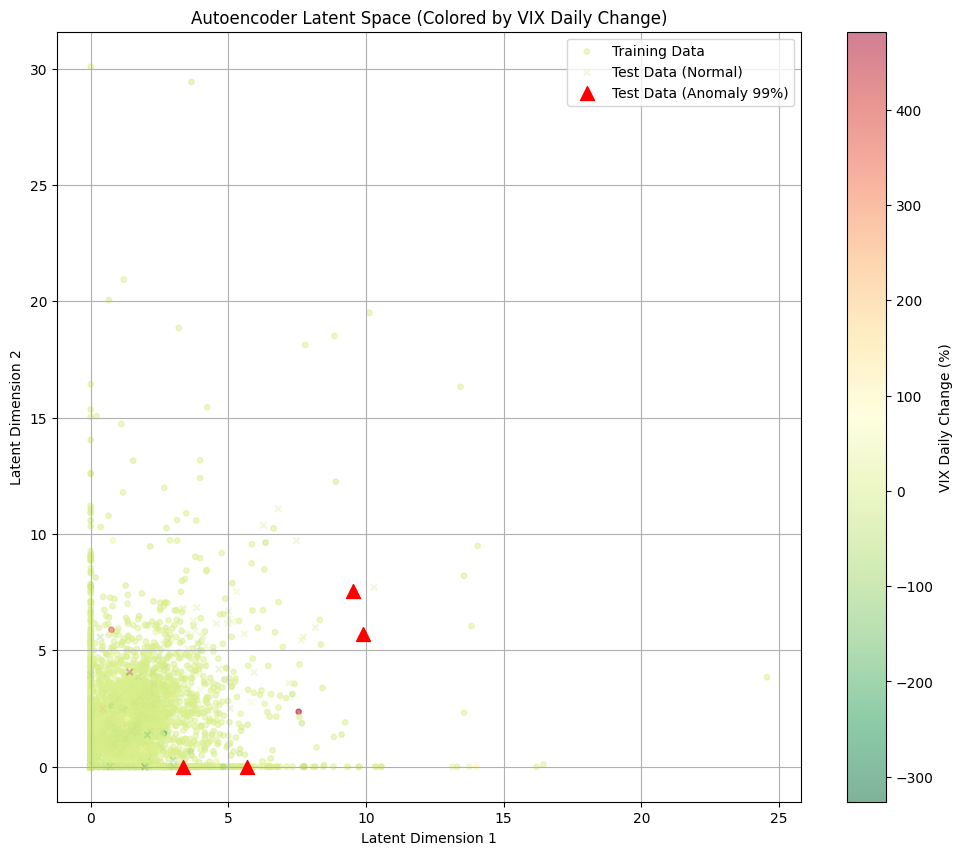

In [ ]:
def build_and_visualize_latent_space(X_train_data, X_test_data, market_returns_df, train_mask_idx, test_mask_idx, feature_names, encoding_dim=2):
    """
    Builds a special autoencoder with a 2D latent space for visualization,
    trains it, and plots the latent space colored by VIX Daily Change.
    """
    input_dim_2d = X_train_data.shape[1]

    # Build a separate autoencoder with encoding_dim=2 for visualization
    ae_2d, enc_2d = build_autoencoder(input_dim_2d, encoding_dim=encoding_dim, hidden_dims=[32, 16])

    print(f"\nTraining 2D latent space autoencoder (encoding_dim={encoding_dim})...")
    # Train the 2D AE (can use fewer epochs as it's mainly for visualization)
    train_autoencoder(ae_2d, X_train_data, epochs=50, batch_size=64, validation_split=0.15, patience=10)
    print("2D Autoencoder training complete.")

    # Get latent space representations for training data
    Z_train = enc_2d.predict(X_train_data, verbose=0)
    Z_test = enc_2d.predict(X_test_data, verbose=0)

    # Prepare VIX data for coloring
    vix_train = market_returns_df.loc[train_mask_idx, 'VIX'].pct_change().dropna()
    vix_test = market_returns_df.loc[test_mask_idx, 'VIX'].pct_change().dropna()

    # Align VIX data with Z_train/Z_test indices
    Z_train_df = pd.DataFrame(Z_train, index=X_train_data.index)
    Z_test_df = pd.DataFrame(Z_test, index=X_test_data.index)

    # Ensure VIX values align with the latent space data
    # Drop dates where VIX data is not available after pct_change()
    vix_train_aligned = vix_train.reindex(Z_train_df.index).fillna(0) # Fillna with 0 for missing VIX changes
    vix_test_aligned = vix_test.reindex(Z_test_df.index).fillna(0)

    # Plot latent space for training data
    plt.figure(figsize=(12, 10))
    scatter_train = plt.scatter(Z_train_df.iloc[:, 0], Z_train_df.iloc[:, 1],
                                c=vix_train_aligned, cmap='RdYlGn_r', alpha=0.5, s=15, label='Training Data')
    plt.colorbar(scatter_train, label='VIX Daily Change (%)')

    # Plot latent space for test data, highlighting anomalies
    test_anomalies_2d = anomaly_results_df[anomaly_results_df['anomaly_flag_99']].index.intersection(Z_test_df.index)

    # Only scatter test data points that are not anomalies
    normal_test_indices = Z_test_df.index.difference(test_anomalies_2d)

    if not normal_test_indices.empty:
        scatter_test_normal = plt.scatter(Z_test_df.loc[normal_test_indices, 0], Z_test_df.loc[normal_test_indices, 1],
                                          c=vix_test_aligned.loc[normal_test_indices], cmap='RdYlGn_r',
                                          marker='x', alpha=0.3, s=20, label='Test Data (Normal)')

    if not test_anomalies_2d.empty:
        scatter_test_anomalies = plt.scatter(Z_test_df.loc[test_anomalies_2d, 0], Z_test_df.loc[test_anomalies_2d, 1],
                                            color='red', marker='^', s=100, zorder=5, label='Test Data (Anomaly 99%)')

    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Autoencoder Latent Space (Colored by VIX Daily Change)')
    plt.legend()
    plt.grid(True)
    plt.show()

build_and_visualize_latent_space(X_train, X_test, market_returns, train_mask, test_mask, ae_features)


### Explanation of Latent Space Visualization

This visualization is a powerful way for me to assess if the autoencoder has learned meaningful, structural relationships in the market data. By projecting the high-dimensional market returns into a 2D latent space and coloring points by a proxy for market regime (like VIX Daily Change), I can observe patterns. For instance, if periods of high VIX change (indicating market stress) cluster together, it suggests the autoencoder is capturing these underlying structures. This provides confidence that the model isn't just memorizing data but is truly learning the "geometry" of normal market behavior, allowing it to better identify deviations.


---

## 8. Benchmarking Anomaly Detection: Autoencoder vs. Baselines

To fully justify the autoencoder's deployment, I need to compare its performance against simpler, more traditional anomaly detection methods. This benchmarking provides critical context and helps quantify the added value of a deep learning approach for Apex Asset Management. I'll compare it with Isolation Forest and Mahalanobis distance.

For evaluation, I will use the `known_anomaly_dates` as a sparse "ground truth" to calculate ROC AUC and Average Precision scores. It's important to note that market data isn't perfectly labeled, so these metrics provide a directional comparison rather than absolute performance.


### Implementing and Comparing Baseline Models

**Isolation Forest:** This algorithm isolates anomalies by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Anomalies are points that require fewer splits to be isolated. The anomaly score $s(x)$ for a point $x$ is:
$$
s(x) = 2^{-\frac{E[h(x)]}{c(n)}}
$$
where $E[h(x)]$ is the average path length to isolate $x$, and $c(n)$ is the expected path length for a dataset of size $n$. A score closer to 1 indicates a higher likelihood of anomaly.

**Mahalanobis Distance:** This is a measure of the distance between a point and a distribution. It is a multi-dimensional generalization of the idea of measuring how many standard deviations away a point is from the mean of a distribution. For a point $x$ and a distribution with mean $\mu$ and covariance matrix $\Sigma$, the Mahalanobis distance $D_M(x)$ is:
$$
D_M(x) = \sqrt{(x - \mu)^T \Sigma^{-1} (x - \mu)}
$$
Higher values indicate greater deviation from the normal distribution.


In [ ]:
def compare_anomaly_detectors(X_train_data, X_test_data, anomaly_df, known_dates_list, ae_model, ae_test_errors):
    """
    Compares the Autoencoder's performance against Isolation Forest and Mahalanobis distance.
    Uses known anomaly dates as sparse ground truth for evaluation metrics.
    """
    print("\n--- Comparing Anomaly Detection Models ---")

    # 1. Isolation Forest
    print("Running Isolation Forest...")
    iso_forest = IsolationForest(contamination=0.01, random_state=42) # Contamination based on expected anomaly rate
    iso_forest.fit(X_train_data)
    iso_scores = -iso_forest.decision_function(X_test_data) # Higher score = more anomalous

    # 2. Mahalanobis Distance
    print("Calculating Mahalanobis Distance...")
    # Calculate inverse covariance matrix from training data
    cov_inv = np.linalg.pinv(np.cov(X_train_data, rowvar=False))
    mean_train = np.mean(X_train_data, axis=0)

    mahal_scores = np.array([distance.mahalanobis(x, mean_train, cov_inv) for x in X_test_data.values])

    # Prepare ground truth labels (1 for known anomaly, 0 otherwise)
    # This is a sparse ground truth for market data
    test_dates = anomaly_df.index
    y_true_labels = np.array([1 if d in known_dates_list else 0 for d in test_dates]).astype(int)

    # Store model scores
    model_scores = {
        'Autoencoder': ae_test_errors,
        'Isolation Forest': iso_scores,
        'Mahalanobis': mahal_scores
    }

    print("\nEvaluation Metrics (using known market events as ground truth):")
    if y_true_labels.sum() > 0: # Only evaluate if there are known anomalies in the test set
        for name, scores in model_scores.items():
            auc = roc_auc_score(y_true_labels, scores)
            ap = average_precision_score(y_true_labels, scores)
            print(f"{name:20s}: ROC AUC={auc:.3f}, Avg Precision={ap:.3f}")

        # Visualize Precision-Recall Curves if meaningful (enough positive samples)
        plt.figure(figsize=(10, 7))
        for name, scores in model_scores.items():
            precision, recall, _ = precision_recall_curve(y_true_labels, scores)
            plt.plot(recall, precision, label=f'{name} (AP={average_precision_score(y_true_labels, scores):.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve for Anomaly Detection Baselines')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No known anomaly dates found in the test set for quantitative evaluation.")
        print("Qualitative comparison will rely on visual inspection of flagged dates.")

compare_anomaly_detectors(X_train, X_test, anomaly_results_df, known_anomaly_dates, autoencoder, test_recon_errors)



--- Comparing Anomaly Detection Models ---
Running Isolation Forest...
Calculating Mahalanobis Distance...

Evaluation Metrics (using known market events as ground truth):
No known anomaly dates found in the test set for quantitative evaluation.
Qualitative comparison will rely on visual inspection of flagged dates.


### Explanation of Baseline Comparison

The comparison against Isolation Forest and Mahalanobis distance is vital for a Quant Analyst like me. While the autoencoder might capture more complex, non-linear dependencies, it's good practice to understand how it stacks up against simpler, faster methods. Isolation Forest is a tree-based method, robust to high-dimensional data, while Mahalanobis distance is a statistical measure assuming multivariate normality. The Precision-Recall curves, if calculable, provide a visual summary of the trade-off between identifying all true anomalies (recall) and minimizing false positives (precision) across various thresholds. This exercise helps Apex Asset Management choose the most appropriate tool for a given anomaly detection task, balancing complexity, interpretability, and performance.


---

## 9. Beyond Detection: Introduction to Variational Autoencoders for Generative Finance

While our autoencoder is excellent for anomaly detection, there's a powerful extension called the Variational Autoencoder (VAE) that allows for generative modeling. For an investment professional, this capability opens doors to generating synthetic market data for stress testing, scenario simulation, and even data augmentation. It's a conceptual bridge from detecting anomalies to creating realistic data.


### Variational Autoencoder (VAE) Architecture and Loss

A VAE differs from a standard autoencoder by mapping the input to a probability distribution in the latent space (mean and variance) rather than a fixed point. This allows for smooth and continuous latent spaces. The VAE's loss function combines the reconstruction error with a Kullback-Leibler (KL) divergence term, which acts as a regularizer, forcing the latent distribution to be close to a standard normal distribution.

The VAE loss function $\mathcal{L}_{VAE}$ is composed of two parts:
1.
**Reconstruction Loss:** Measures how well the input is reconstructed, typically MSE.
$\mathcal{L}_{recon} = \|x_i - D(\tilde{z}_i)\|^2$ where $\tilde{z}_i$ is a sample from the latent distribution.
2.
**KL Divergence Loss:** A regularization term that measures the difference between the learned latent distribution $q(z|x_i) = \mathcal{N}(\mu_i, \Sigma_i)$ and a prior standard normal distribution $p(z) = \mathcal{N}(0, I)$.
$$
\mathcal{L}_{KL} = -\frac{1}{2} \sum_{j=1}^{d} (1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2)
$$
where $d$ is the latent dimension, and $\mu_j$ and $\sigma_j^2$ are the mean and variance of the $j$-th latent dimension.
The total VAE loss is:
$$
\mathcal{L}_{VAE} = \mathcal{L}_{recon} + \beta \mathcal{L}_{KL}
$$
where $\beta$ is a weighting factor.


### VAE Implementation (Brief Demonstration)


In [ ]:
# Reparameterization trick for VAE
def sampling(args):
    """
    Implements the reparameterization trick to sample from the latent space.
    """
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # data is typically (x, y) or x. For VAE, x is also y.
        x_input = data[0] if isinstance(data, (list, tuple)) else data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x_input)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.keras.ops.mean(
                tf.keras.ops.square(x_input - reconstruction), axis=-1
            )
            kl_loss = -0.5 * tf.keras.ops.mean(
                1 + z_log_var - tf.keras.ops.square(z_mean) - tf.keras.ops.exp(z_log_var),
                axis=-1,
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        # inputs could be (x, y) if called directly by model.fit or model.predict
        x_input = inputs[0] if isinstance(inputs, (list, tuple)) else inputs
        z_mean, z_log_var, z = self.encoder(x_input)
        reconstruction = self.decoder(z)
        return reconstruction

def build_vae_components(input_dim, latent_dim=4, hidden_dims=[32, 16], dropout_rate=0.2):
    """
    Constructs the encoder and decoder components for a Variational Autoencoder.
    """
    # Encoder
    encoder_inputs = Input(shape=(input_dim,), name='encoder_input_vae')
    x = encoder_inputs
    for i, dim in enumerate(hidden_dims):
        x = Dense(dim, activation='relu', name=f'vae_encoder_hidden_{i+1}')(x)
        x = BatchNormalization(name=f'vae_encoder_bn_{i+1}')(x)
        x = Dropout(dropout_rate, name=f'vae_encoder_dropout_{i+1}')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z_sampling')([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='vae_encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling_input')
    x = latent_inputs
    for i, dim in enumerate(reversed(hidden_dims)):
        x = Dense(dim, activation='relu', name=f'vae_decoder_hidden_{i+1}')(x)
        x = BatchNormalization(name=f'vae_decoder_bn_{i+1}')(x)
        x = Dropout(dropout_rate, name=f'vae_decoder_dropout_{i+1}')(x)
    decoder_outputs = Dense(input_dim, activation='linear', name='vae_output_layer')(x)
    decoder = Model(latent_inputs, decoder_outputs, name='vae_decoder')

    return encoder, decoder

# Build VAE components
vae_encoder, vae_decoder = build_vae_components(input_dim, latent_dim=4)

# Instantiate the VAE model
vae_model = VAE(vae_encoder, vae_decoder)
vae_model.compile(optimizer='adam', loss='mse') # Added a placeholder loss here

print("\nVAE Model Summary:")
vae_model.build((None, input_dim)) # Build the model to print summary
vae_model.summary()

print("\nTraining VAE...")
# Train VAE (can be shorter epochs for demo)
vae_model.fit(X_train, X_train, epochs=50, batch_size=64, validation_split=0.15, verbose=0,
              callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
print("VAE trained successfully.")


VAE Model Summary:


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vae_encoder (Functional)        │ ((None, 4), (None, 4), │         1,336 │
│                                 │ (None, 4))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vae_decoder (Functional)        │ (None, 14)             │         1,278 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,614 (10.21 KB)

 Trainable params: 2,422 (9.46 KB)

 Non-trainable params: 192 (768.00 B)


Training VAE...
VAE trained successfully.


### Making Predictions with the VAE

In [ ]:
# Use the VAE model to reconstruct the test data
X_test_reconstructed_vae = vae_model.predict(X_test)

# Display the first few rows of original vs. reconstructed data
print("Original Test Data (first 5 rows):")
display(X_test.head())

print("\nReconstructed Test Data (first 5 rows from VAE):")
display(pd.DataFrame(X_test_reconstructed_vae, index=X_test.index, columns=X_test.columns).head())

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Original Test Data (first 5 rows):


,EmergMkt,Japan,Gold,MedBond,ShortBond,LongBond,Oil,USD,Europe,DJIA,SP500,NASDAQ,Russell2000,VIX
Date,,,,,,,,,,,,,,
2023-01-03,0.465039,0.350239,0.742462,1.728499,0.864093,1.924124,-1.479852,2.090835,0.814386,-0.057215,-0.349147,-0.577076,-0.393977,0.660618
2023-01-04,1.686815,-0.774218,0.838007,1.691691,0.995292,1.376815,-2.077884,-0.716949,1.237483,0.306095,0.561537,0.444352,0.745562,-0.514069
2023-01-05,-0.183572,-1.051076,-1.168164,-0.347471,-1.497575,0.409157,0.324782,1.796222,-0.613817,-0.881810,-0.952479,-1.075804,-0.699628,0.214510
2023-01-06,1.167686,1.908831,1.690966,2.856932,4.016135,1.854207,0.041882,-2.582402,1.735798,1.745301,1.769136,1.761949,1.372220,-0.764076
2023-01-09,0.411050,0.151804,0.180386,0.543993,0.992018,0.525400,0.693830,-1.213261,0.402078,-0.310107,-0.094009,0.399857,0.082580,0.451704



Reconstructed Test Data (first 5 rows from VAE):


,EmergMkt,Japan,Gold,MedBond,ShortBond,LongBond,Oil,USD,Europe,DJIA,SP500,NASDAQ,Russell2000,VIX
Date,,,,,,,,,,,,,,
2023-01-03,0.043226,0.008871,0.004260,-0.028212,-0.026245,0.021704,0.012339,-0.037261,0.021252,-0.002027,0.062496,0.023055,0.027955,-0.117099
2023-01-04,-0.185030,-0.168818,-0.021579,0.170604,0.095944,0.180894,-0.127647,-0.005755,-0.153887,-0.200347,-0.195109,-0.212563,-0.222015,0.209529
2023-01-05,-0.596465,-0.538309,0.029335,0.518793,0.279936,0.490240,-0.383382,0.145623,-0.617165,-0.606852,-0.643354,-0.672707,-0.629758,0.711982
2023-01-06,0.156127,0.175953,-0.031535,-0.116944,-0.032634,-0.127772,0.103285,-0.125323,0.138367,0.228481,0.148056,0.193650,0.250578,-0.207050
2023-01-09,0.113496,0.077929,-0.013287,-0.096158,-0.050642,-0.077235,0.065998,-0.060196,0.099349,0.114995,0.135113,0.135797,0.113664,-0.206887


### Explanation of VAE for Finance

For Apex Asset Management, the VAE is conceptually significant:
*   **Generative Capabilities:** Unlike the standard autoencoder which is purely discriminative (for anomaly detection), the VAE can *generate* new, plausible data points by sampling from its smooth latent space and passing them through the decoder. This is crucial for creating synthetic financial data.
*   **Synthetic Data Generation:** This capability can be used for:
    *   **Stress Testing:** Generating extreme but realistic market scenarios for portfolio stress testing.
    *   **Scenario Simulation:** Creating various market scenarios to evaluate strategy performance.
    *   **Data Augmentation:** Expanding limited datasets, particularly for rare events, to improve model training.

This brief demonstration of the VAE highlights how deep learning architectures can extend from anomaly detection to advanced generative applications, providing even more sophisticated tools for financial professionals.


## QuantUniversity License

© QuantUniversity 2025  
This notebook was created for **educational purposes only** and is **not intended for commercial use**.  

- You **may not copy, share, or redistribute** this notebook **without explicit permission** from QuantUniversity.  
- You **may not delete or modify this license cell** without authorization.  
- This notebook was generated using **QuCreate**, an AI-powered assistant.  
- Content generated by AI may contain **hallucinated or incorrect information**. Please **verify before using**.  

All rights reserved. For permissions or commercial licensing, contact: [info@qusandbox.com](mailto:info@qusandbox.com)